In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os 
from tqdm import tqdm

import multiprocessing as mp

import time 
from natsort import natsorted
import moviepy.video.io.ImageSequenceClip

import copy 

import pickle as pkl

In [3]:
sys.setrecursionlimit(10000) 

In [4]:
from simulation import *
from visualizer import renderParticles, drawTree, plotter

In [5]:
plt.ioff()

In [6]:

def leapfrog(r, t_start=0, t_end=10, N=1e4, L=2, theta=0.5, multi=False, epsilon=1e-3, m_scale=1e3):
    dt = (t_end - t_start)/N

    tpoints = np.arange(t_start, t_end, dt)
    xpoints = []
    trees = []
    
    acc = np.zeros((len(r), 2))
    pos = r[:, 0:2]
    vel = r[:, 2: ]
    
    n_cpu = mp.cpu_count()
    pool = mp.Pool(processes=n_cpu)

    for t in tqdm(tpoints):
        # have to .copy() because we are updating the same array and that causes memory issues 
        xpoints.append(np.hstack((pos, vel, acc)))
        
        # use current acceleration to kick velocity a half time step
        vel = vel + acc * dt / 2 
        # drift the position using the kicked (half time step) velocity 
        pos = pos + vel * dt 
        
        # update acceleration block. construct the quadtree for force modeling 
        root = leaf(bbox=np.array([[-L/2, -L/2], [L/2, L/2]]))
        # which we then can immediately turn into a tree 
        for p in pos: 
            root = assignParticle(p, root)
        trees.append(root)

        # calculate acceleration 
        
#         drawTree(AX, root)
        # multiprocessing is good for large N (> 1000), can be optimized 
#         if multi: 
#             acc = np.vstack([pool.apply_async(f_multipole, args=(p, root, root.length[0], 
#                                                                 theta, epsilon, m_scale)).get() for p in pos])
#         else: 
        acc = np.array([f_multipole(p, root, root.length[0], theta=theta, epsilon=epsilon, m_scale=1e3) 
                    for p in pos])

        # kick velocity a half time step using new updated acceleration  
        vel = vel + acc * dt / 2 
        
        # fix positions based on boundary conditions 
        pos[pos[:, 0] > L/2, 0] = pos[pos[:, 0] > L/2, 0] - L
        pos[pos[:, 0] < -L/2, 0] = pos[pos[:, 0] < -L/2, 0] + L
        pos[pos[:, 1] > L/2, 1] = pos[pos[:, 1] > L/2, 1] - L
        pos[pos[:, 1] < -L/2, 1] = pos[pos[:, 1] < -L/2, 1] + L
        
        
    pool.close()
    pool.join()
        
    return tpoints, np.array(xpoints), np.array(trees)



<IPython.core.display.Javascript object>


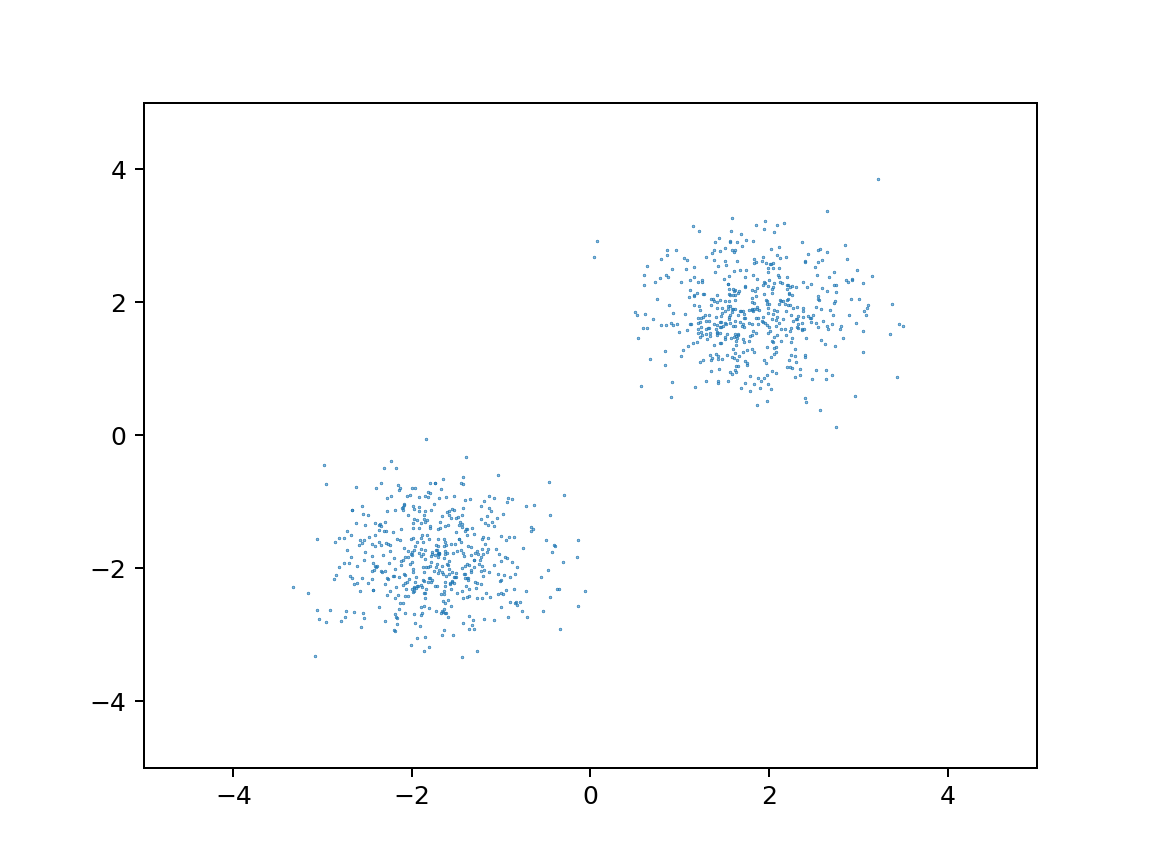

In [8]:

n = 500
particles = np.random.random((n, 4)) * 2 - 1

particles1 = np.random.normal(1.85, 0.6, (n, 4))
particles2 = np.random.normal(-1.85, 0.6, (n, 4))
particles2[:, 0] += 0.1

particles = np.vstack((particles1, particles2))

particles[:, 2:] = 0
plt.scatter(particles[:, 0], particles[:, 1], s= 0.1)
#plt.scatter(particles_list[-1][:, 0], particles_list[-1][:, 1], s=0.1)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [ ]:

tpoints, particles_list, trees = leapfrog(particles.copy(), t_start=0, t_end=20, N=2e3, L=10, theta=0.5,
                                         epsilon=1e-4, m_scale=1e5, multi=False)


 19%|█████████████████████████████▉                                                                                                                                 | 376/2000 [19:03<1:33:55,  3.47s/it]

In [ ]:

tstart = time.time() 

print('[{:.2f}] Creating plot directory ...'.format(time.time() - tstart))
plot_dir = '{}/{}'.format(os.path.abspath(os.getcwd()), 'L{}n{}'.format(trees[0].length[0], n))
if not os.path.isdir(plot_dir):
    os.mkdir(os.path.join(plot_dir))

print('[{:.2f}] Initializing multiprocessing ...'.format(time.time() - tstart))
n_cpu = mp.cpu_count()
pool = mp.Pool(processes=n_cpu)

mp_trees = np.array_split(trees, n_cpu)
mp_particles = np.array_split(particles_list, n_cpu)
mp_tpoints = np.array_split(np.arange(len(tpoints)), n_cpu)
    
print('[{:.2f}] Creating plots ...'.format(time.time() - tstart))
for i in range(n_cpu):
    pool.apply_async(renderParticles, args=(mp_particles[i], mp_trees[i], mp_tpoints[i], plot_dir))

pool.close()
pool.join()
print('[{:.2f}] Multiprocess concluded ...'.format(time.time() - tstart))


print('[{:.2f}] Creating video ...'.format(time.time() - tstart))

fps=60 #number of frames per second
image_files = natsorted([os.path.join(plot_dir,img) for img in os.listdir(plot_dir) if img.endswith(".png")], reverse=False)
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('test.mp4')

print('[{:.2f}] Video created ...'.format(time.time() - tstart))

_ = [os.remove(image_file) for image_file in image_files]
os.rmdir(plot_dir)
print('[{:.2f}] Directory cleaned ...'.format(time.time() - tstart))


In [ ]:
with open('./data/sim.pkl', 'wb') as f:  # open a text file
    pkl.dump({'tpoints': tpoints, 'particles_list': particles_list, 'trees': trees}, f) # serialize the list
f.close()

In [ ]:
with open('./data/sim.pkl', 'rb') as f:
    sim_dict = pkl.load(f)
    
tpoints = sim_dict['tpoints']
particles_list = sim_dict['particles_list']
trees = sim_dict['trees']

n = particles_list[0].shape[0]